In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os

os.chdir("/content/drive/My Drive/Colab Notebooks")

In [0]:
!ls

 best_model.pth
'Copy of Copy of sample_build_model_pytorch (1).ipynb'
'Copy of Copy of sample_build_model_pytorch (2).ipynb'
'Copy of Copy of sample_build_model_pytorch.ipynb'
'Copy of Plotting and visualization with matplotlib.ipynb'
'Copy of PyTorch_cifar10_tutorial_ROB313_2018.ipynb'
'Copy of Sample building CNN for MNIST classification.ipynb'
'Copy of sample_build_model_pytorch.ipynb'
'Copy of training_tomato_for_webapp.ipynb'
 dataset_final_100.zip
 lecture1.ipynb
 object_detection_retinanet.ipynb
'Overfitting & underfitting test'
 sample_inference.jpg
 test_colab.ipynb
'underfitting and overfitting.ipynb'


In [0]:
!unzip data.zip

unzip:  cannot find or open data.zip, data.zip.zip or data.zip.ZIP.


In [0]:
!ls

 best_model.pth
'Copy of Copy of sample_build_model_pytorch (1).ipynb'
'Copy of Copy of sample_build_model_pytorch (2).ipynb'
'Copy of Copy of sample_build_model_pytorch.ipynb'
'Copy of Plotting and visualization with matplotlib.ipynb'
'Copy of PyTorch_cifar10_tutorial_ROB313_2018.ipynb'
'Copy of Sample building CNN for MNIST classification.ipynb'
'Copy of sample_build_model_pytorch.ipynb'
'Copy of training_tomato_for_webapp.ipynb'
 dataset_final_100.zip
 lecture1.ipynb
 object_detection_retinanet.ipynb
'Overfitting & underfitting test'
 sample_inference.jpg
 test_colab.ipynb
'underfitting and overfitting.ipynb'


##MNIST Test



In [0]:
import torch
from torchvision import transforms
import numpy as np
import pandas as pd # read table-like data
import os
import cv2

In [0]:
np.linspace(3 , 5 , 5)

array([3. , 3.5, 4. , 4.5, 5. ])

In [0]:
import os, glob
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import cv2

class BasicDataset(Dataset):
    def __init__(self, data_path):
        # "mnist/*"
        self.data_dirs = glob.glob(os.path.join(data_path, "*"))
        # "mnist/*/*.jpg"
        self.data_paths = glob.glob(os.path.join(data_path, "*", "*.jpg"))
    
    def __len__(self):
        return len(self.data_paths)
    
    def __getitem__(self, idx):
        # Step 1: read image and label into numpy arrays
        image = cv2.imread(self.data_paths[idx])
        label = self.__get_label(self.data_paths[idx])

        # Step 2: convert numpy arrays into torch tensors for processing
        image = transforms.ToTensor()(image)
        label = torch.tensor(label)

        # Step 3: convert torch CPU tensors to torch GPU tensors
        image = image.cuda()
        label = label.cuda()

        return image, label

    def __get_label(self, path):
        #"mnist/1/198.jpg" ~> 1
        # Step 1: extract "mnist/1"
        dirname = os.path.dirname(path)
        # Step 2: extract "1"
        basename = os.path.basename(dirname)
        # Step 3: convert "1" to 1
        label = int(basename)
        return label

In [0]:
dataset = BasicDataset(data_path="small_mnist")

In [0]:
dataloader = DataLoader(dataset, 
                        batch_size=16, 
                        shuffle=True, 
                        num_workers=16)

In [0]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512,3)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 55.4MB/s]


In [0]:
# try to pass data into the model
for image,label in dataloader:
  print("image = {}, label = {}".format(image, label))
  output = model(image)
  print(output.shape)
  break

KeyboardInterrupt: ignored

In [0]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

loss_analysis = 0;
num_epoch = 10
best_loss = 100000000
for epoch in range(num_epoch):
  loss_analysis = 0
  for step,(x,y) in enumerate(dataloader):
    preds = model(x)
    
    loss = loss_function(preds,y.long())
    # print("pred = {}, y = {}".format(preds, y.long()))
    loss_analysis += loss
    if ((step + 1) % 10 == 0):
        loss_analysis /= 10
        print("---Loss after 10 step = {}---".format(loss_analysis))
        loss_analysis = 0
    loss.backward() # calculate gradient 
    optimizer.step() # update model parameters
    optimizer.zero_grad()
    print(f'epoch {epoch+1} step {step+1} loss:{loss.item()}')
    if loss.item() < best_loss:
      best_loss = loss.item()
      torch.save(model.state_dict(),f"best_model.pth")

##Disk Classification

In [0]:
import torch
import torchvision
import numpy as np
import pandas as pd # read table-like data
import os
import cv2
import matplotlib.pyplot as plt

In [0]:
from torchvision import transforms

class RoomDataset(torch.utils.data.Dataset):
  def __init__(self,data_path):
    super().__init__()
    self.data_path = data_path
    self.csv_path = os.path.join(data_path,'annotation.csv')
    self.data = pd.read_csv(self.csv_path).values
    self.mapping_label = {
        "GROUP-OF-COUNT":0,
        "SCRATCH":1,
        "WHOLE-SURFACE":2,
    }
    print(f"data has {len(self.data)} samples.")
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self,index):
    image_name, room_type = self.data[index]
    image_path = os.path.join(self.data_path,image_name)
    image = cv2.imread(image_path)
    image = cv2.resize(image,(256,256))
    image = transforms.ToTensor()(image)
    label = self.mapping_label[room_type]
    return image,label

In [0]:
dataset = RoomDataset('/content/drive/My Drive/AI_Learn_NEW')

data has 747 samples.


In [0]:
dataloader = torch.utils.data.DataLoader(dataset,batch_size=32,shuffle=True,num_workers=10)

Build model

In [0]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, 3)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
# try to pass data into the model
for image,label in dataloader:
  output = model(image)
  print(output.shape)
  break

torch.Size([32, 3])


In [0]:
# vis = visdom.Visdom(server='0.0.0.0', port='6006')

NameError: ignored

epoch 1 step 1 loss:1.1643511056900024
epoch 1 step 2 loss:0.9321860074996948
epoch 1 step 3 loss:0.7398155331611633
epoch 1 step 4 loss:0.5771719217300415
epoch 1 step 5 loss:0.5709444284439087
epoch 1 step 6 loss:0.6461389064788818
epoch 1 step 7 loss:0.6412171125411987
epoch 1 step 8 loss:0.6142600774765015
epoch 1 step 9 loss:0.4272719621658325
---Loss after 10 step = 0.7028226256370544---
epoch 1 step 10 loss:0.7148696780204773
epoch 1 step 11 loss:0.40301409363746643
epoch 1 step 12 loss:0.32085105776786804
epoch 1 step 13 loss:0.44892245531082153
epoch 1 step 14 loss:0.47970956563949585
epoch 1 step 15 loss:0.39361047744750977
epoch 1 step 16 loss:0.32675403356552124
epoch 1 step 17 loss:0.41586431860923767
epoch 1 step 18 loss:0.33015748858451843
epoch 1 step 19 loss:0.5263663530349731
---Loss after 10 step = 0.4094952642917633---
epoch 1 step 20 loss:0.449702650308609
epoch 1 step 21 loss:0.32297876477241516
epoch 1 step 22 loss:0.430345743894577
epoch 1 step 23 loss:0.2026032

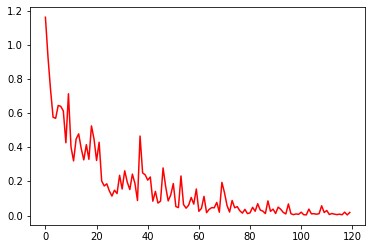

In [0]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

loss_analysis = 0;
num_epoch = 5
count = 0
best_loss = 100000000
loss_values = []
iterator_values = []
for epoch in range(num_epoch):
  loss_analysis = 0
  for step,(x,y) in enumerate(dataloader):
    count += 1
    if (count % 5 == 0):
      iterator_values.append(count)
    preds = model(x)
    loss = loss_function(preds,y.long())
    # print("pred = {}, y = {}".format(preds, y.long()))
    loss_analysis += loss
    loss_values.append(loss)
    if ((step + 1) % 10 == 0):
      loss_analysis /= 10
      print("---Loss after 10 step = {}---".format(loss_analysis))
      loss_analysis = 0
    loss.backward() # calculate gradient 
    optimizer.step() # update model parameters
    optimizer.zero_grad()
    print(f'epoch {epoch+1} step {step+1} loss:{loss.item()}')
    if loss.item() < best_loss:
      best_loss = loss.item()
      torch.save(model.state_dict(),f"best_model.pth")
plt.plot(np.array(iterator_values), np.array(loss_values), "r")
plt.xlabel("Number of epoch")
plt.ylabel("Loss")
plt.title("Result of training")
plt.show()

In [0]:
# torch.save(model.state_dict(),'./model_checkpoint.pth') # save model after training
model.load_state_dict(torch.load('./best_model.pth'))# retrieve model from file 

<All keys matched successfully>

<All keys matched successfully>

In [0]:
# Inference
# !wget https://www.dbsbathrooms.co.uk/news/wp-content/uploads/2019/11/iStock-990249406-1024x683.jpg -O sample_inference.jpg
!ls
os.chdir("/content/drive/My Drive/AI_Learn_NEW")

 best_model.pth
'Copy of Copy of sample_build_model_pytorch (1).ipynb'
'Copy of Copy of sample_build_model_pytorch (2).ipynb'
'Copy of Copy of sample_build_model_pytorch.ipynb'
'Copy of Plotting and visualization with matplotlib.ipynb'
'Copy of PyTorch_cifar10_tutorial_ROB313_2018.ipynb'
'Copy of Sample building CNN for MNIST classification.ipynb'
'Copy of sample_build_model_pytorch.ipynb'
'Copy of training_tomato_for_webapp.ipynb'
 dataset_final_100.zip
 lecture1.ipynb
 object_detection_retinanet.ipynb
'Overfitting & underfitting test'
 sample_inference.jpg
 test_colab.ipynb
'underfitting and overfitting.ipynb'


In [0]:
image = cv2.imread('./GROUP-OF-COUNT_918M000360_1_1_B.bmp')
image = cv2.resize(image,(256,256))
model.eval() # change model to evaluation mode
image_tensor = transforms.ToTensor()(image)
prediction = model(image_tensor[None,...])

In [0]:
label_index = torch.argmax(prediction[0])
probality = torch.nn.functional.softmax(prediction[0])[label_index]
label_name = list(dataset.mapping_label.keys())[label_index]
print('label: {} probality: {}'.format(label_name,probality))
print('Result: {}'.format(prediction.shape))

label: GROUP-OF-COUNT probality: 0.9983087778091431
Result: torch.Size([1, 3])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [0]:
image = cv2.imread('./SCRATCH-1_936S185526_1_1_A.bmp')
image = cv2.resize(image,(256,256))
model.eval() # change model to evaluation mode
image_tensor = transforms.ToTensor()(image)
prediction = model(image_tensor[None,...])

In [0]:
label_index = torch.argmax(prediction[0])
probality = torch.nn.functional.softmax(prediction[0])[label_index]
label_name = list(dataset.mapping_label.keys())[label_index]
print('label: {} probality: {}'.format(label_name,probality))
print('Result: {}'.format(prediction.shape))

label: SCRATCH probality: 0.9997910857200623
Result: torch.Size([1, 3])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [0]:
image = cv2.imread('./WHOLE-SURFACE_938T009004_1_1_B.bmp')
image = cv2.resize(image,(256,256))
model.eval() # change model to evaluation mode
image_tensor = transforms.ToTensor()(image)
prediction = model(image_tensor[None,...])

In [0]:
label_index = torch.argmax(prediction[0])
probality = torch.nn.functional.softmax(prediction[0])[label_index]
label_name = list(dataset.mapping_label.keys())[label_index]
print('label: {} probality: {}'.format(label_name,probality))
print('Result: {}'.format(prediction.shape))

label: WHOLE-SURFACE probality: 0.9995644688606262
Result: torch.Size([1, 3])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
